# Versatile Object Recognition
***
## Table of Contents
***

In [75]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Introduction

## 2. Preparing Data
For simple models (shallow networks, logistic regression, etc.), `ToTensor()` is often sufficient as it rescales image pixel values to the range from 0 to 1. However, for state-of-the-art architectures, it is strongly recommended to re-normalise (standardise) inputs so that each colour channel has zero mean and unit variance. Many pretrained models are trained on such normalised inputs, therefore this approach tends to yield better results than basic normalisation. Furthermore, centring inputs around zero generally results in more stable training and faster convergence, particularly for architectures with activation functions such as tanh or certain weight initialisation schemes.

Let:
- $X_{n, c, h, w}$: Pixel value for image $n$, channel $c$, height $h$, and width $w$.
- $N$: Total number of images.
- $C$: Number of channels (RGB = 3).
- $H, W$: Height and width of an image.

For each batch of images ($\left[B, 3, 32, 32\right]$), 
- Mean per channel:
$$
\mu_{\text{batch, c}} = \dfrac{1}{B \cdot H \cdot W}\sum^{B}_{n=1} \sum^{H}_{h=1} \sum^{W}_{w=1} X_{n, c, h, w}
$$

- Squared mean per channel:

$$
s_{\text{batch, c}} = \dfrac{1}{B \cdot H \cdot W}\sum^{B}_{n=1} \sum^{H}_{h=1} \sum^{W}_{w=1} X^2_{n, c, h, w}
$$

- Mean:
$$
\mu = \dfrac{\sum_{\text{batches}} \mu_{\text{batch, c}}}{n_{\text{batches}}}
$$

Using the identity $\text{Var}(X) = E\left[(X - \mu \right)^2]$ :
- Standard deviation:

\begin{align*}

\sigma &= \sqrt{E\left[X^2\right] - (E\left[X\right])^2} \\
 &= \sqrt{\dfrac{\sum_{\text{batches}} s_{\text{batch, c}}}{n_{\text{batches}}} - \mu^2}

\end{align*}


In [76]:
def get_mean_and_std(train_data):
    train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

    c_sum, c_squared_sum, n_batches = 0, 0, 0
    for data, _ in train_loader:
        # Shape: [batch_size, channel=3, height=32, width=32]
        c_sum += torch.mean(data, dim=[0, 2, 3])
        c_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        n_batches += 1
    mean = c_sum / n_batches
    std = (c_squared_sum / n_batches - mean**2) ** 0.5

    return mean.tolist(), std.tolist()

Or, alternatively:

In [77]:
def get_mean_and_std_simple(train_data):
    # .data -> [n_images, height, width, colour channels]
    data = train_data.data / 255

    mean = data.mean(axis=(0, 1, 2))  # Mean with respect to colour channels
    std = data.std(axis=(0, 1, 2))  # Std with respect to colour channels

    return mean, std

In [78]:
raw_train_data = datasets.CIFAR10(
    root="_datasets", train=True, download=True, transform=transforms.ToTensor()
)
mean, std = get_mean_and_std(raw_train_data)
print(f"Mean: {mean}\nStandard Deviation: {std}")

Mean: [0.4914625287055969, 0.48222312331199646, 0.44661077857017517]
Standard Deviation: [0.24703028798103333, 0.24348397552967072, 0.26159432530403137]


## 3. Data Augmentation
This transform pipeline contains the following data augmentation processes:
- **Resize(size=(32, 32))**:
    - Ensures all input images are reshaped to $32 \times 32$ pixels. 
- **RandomCrop(32, padding=4)**:
    - Pads each side of the $32 \times 32$ images by $4$ pixels, making it $40 \times 40$, then randomly crops back to $32 \times 32$.
    - Introduces local translations and slight spatial variations.
    - Helps the model learn translation-invariant features.
- **RandomHorizontalFlip(p=0.5)**:
    - Each image is horizontally flipped with probability $0.5$ ($= 50$%).
    - Increases data diversity and is appropriate for natural images.
- **ToTensor()**:
    - Converts PIL Images or NumPy arrays to PyTorch tensors, scaling pixel values ranging from $0$ to $1$.
- **Normalize(mean=mean, std=std)**:
    - Standardises each channel by subtracting the dataset mean and dividing by its standard deviation.
    - Ensures input features for the neural network are zero-centred and scale-invariant, enhancing training dynamics.

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(32, 32)),
        transforms.transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=(32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

## 4. Loading Data

In [80]:
train_data = datasets.CIFAR10(
    root="_datasets",
    train=True,
    download=True,
    transform=train_transform,
)

test_data = datasets.CIFAR10(
    root="_datasets",
    train=False,
    download=True,
    transform=test_transform,
)

## 5. Device Agnostic-Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, it is `cuda` instead of `mps`.

In [81]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## 6. Understanding Data

In [82]:
print(
    f"Data size\n X_train: {len(train_data.data)}, X_test: {len(test_data.data)}\n y_train: {len(train_data.targets)}, y_test: {len(test_data.targets)}"
)

Data size
 X_train: 50000, X_test: 10000
 y_train: 50000, y_test: 10000


In [91]:
image, label = train_data[0]

In [84]:
image.shape

torch.Size([3, 64, 64])

The shape of the image tensor `[1, 28, 28]` refers to `[colour channel, height, width]`. Having three colour scales implies a colourful image based on the red, green and blue (RGB).

In [85]:
label

6

In [86]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The CIFAR10 dataset contains 10 different objects with an equal number of samples in each class.

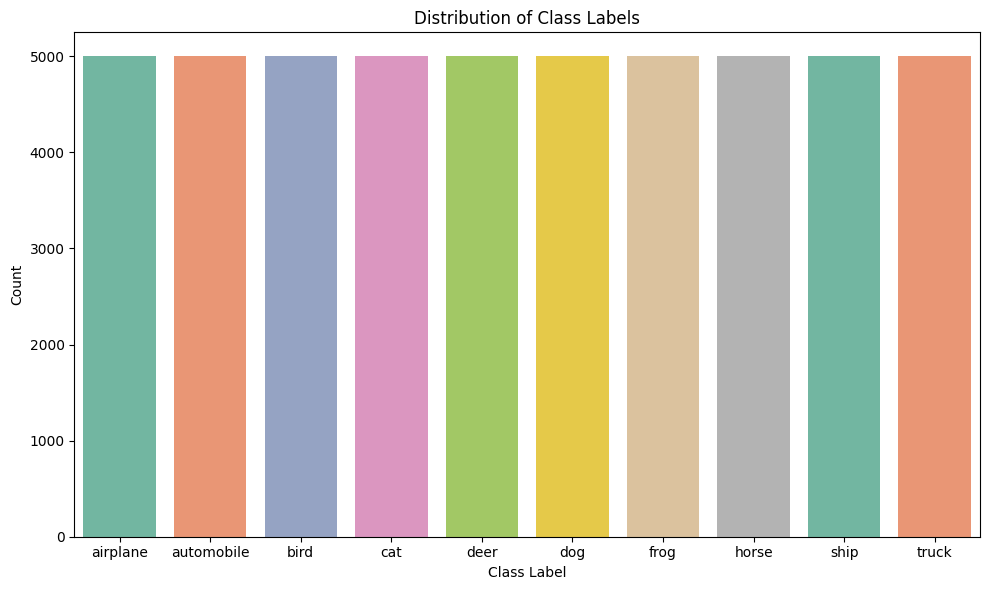

In [ ]:
targets = train_data.targets
class_names_targets = [class_names[i] for i in targets]

unique_vals, counts = np.unique(class_names_targets, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.tight_layout()
plt.show()

Image Shape: (32, 32, 3)


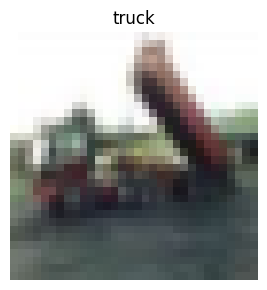

In [103]:
idx = 2
x = train_data.data[idx]

plt.figure(figsize=(3, 3))
plt.imshow(x)
plt.title(class_names[train_data.targets[idx]])

print(f"Image Shape: {x.shape}")
plt.axis(False)
plt.tight_layout()
plt.show()

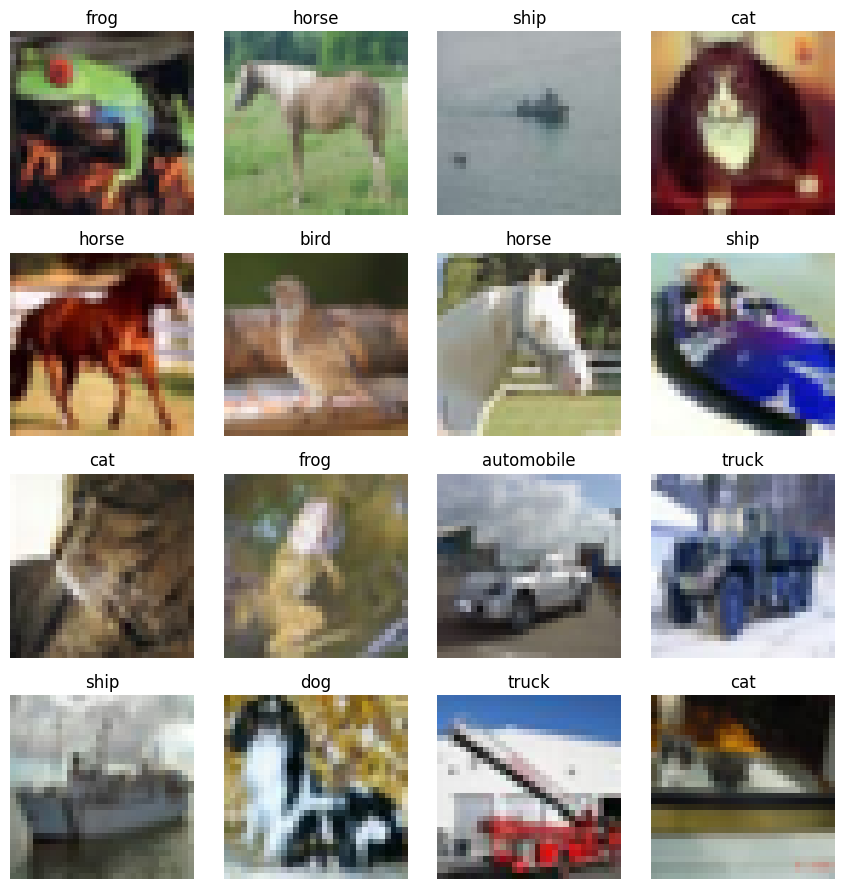

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    img, label = (
        train_data.data[random_idx],
        class_names[train_data.targets[random_idx]],
    )
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(label)
    plt.axis(False)
    plt.tight_layout()
plt.show()

## 7. Preparing DataLoader
`torch.utils.data.DataLoader()` increases the computational efficiency by dividing a large dataset into smaller chunks (called **batches** or **mini-batches**). The size of these batches is controlled by the hyperparameter `batch_size`. Processing data in batches allows gradient descent to be performed once per batch rather than once per epoch, facilitating faster and more stable training process. 

By setting `shuffle=True`, the order of the samples is randomised to promote effective learning and reduce bias of the model. Shuffling should be enabled only for training data, not for test data to ensure reproducible and unbiased evaluation.

Typically, the value of the hyperparameter `batch_size` is set as a power of 2 (32, 64, 128, etc.). For example, with `batch_size = 32`, the `train_data` (50000 samples) will be converted to a `train_dataloader` (50000 // 1563 = 1875 samples per batch), and the `test_data` (10000 samples) will be converted to a `test_dataloader` (10000 // 32 = 313 samples per batch).

In [112]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")


Length of train_dataloader: 1563
Length of test_dataloader: 313


In [113]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 8. Convolutional Neural Network (CNN) Architectures

## References

1. Aladdin Persson. (2020). *Pytorch Quick Tip: Calculate Mean and Standard Deviation of Data*. <br>
https://youtu.be/y6IEcEBRZks?si=JmHfPQWezR1ooX5F

1. stackoverflow. (2021). *How to calculate the mean and the std of cifar10 data*. <br>
https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data